Introduction
--------------

Filtering means preserving certain favored signal frequencies while simultaneously suppressing others. At first, this may seem as easy as simply removing  all the offending frequencies of interest in the Fourier transform and keeping the rest, but, as we will see, practical considerations prohibit this. There are many, many approaches to filtering and here we focus on the popular finite impulse response (FIR) filters. As the name suggests, these filters have no feedback loops, which means that they stop producing output when the input runs out. These are very popular in practice, with blazing-fast on-chip implementations and easy-to-understand, flexible design specifications. This section introduces the main concepts of FIR filter design.

### Finite Impulse Response Filters as Moving Averages

Finite Impulse Response (FIR) filters have the following form: 

$$ y_n = \sum_{k=0}^{M-1} h_k x_{n-k} $$

with real input $ x_n $ and real output $ y_n $. These are called *finite* impulse response because they stop after running out of input (i.e. there is no feedback to keep this going indefinitely on its own). These are also sometimes called *moving average* filters or *all-zero* filters. The word *taps* is used for $ M $  so a *10-tap* filter has $ M=10 $ coefficients. For example, given the two-tap filter, $ h_0 = h_1 = 1/2 $, we have

$$ y_n = x_{n}/2 + x_{n-1}/2 $$

For example, for input $ x_n=1 \hspace{.5em} \forall n \ge 0 $,  $ y_n = 1 \hspace{.5em} \forall n \ge 1  $. Note that we lose one sample in filling the filter for $ n=0 $ which means we have to wait one sample for a valid filter output. This is the filter's  *transient* state.  As another example, for input 
 $ x_n= \exp \left( j\pi n \right)  \hspace{.5em} \forall n\ge 0 $, then $ y_n=0 \forall n \ge 1  $. These two cases show that this moving average has eliminated   the highest frequency signal ($ \omega=\pi $) and preserved the lowest frequency signal ($ \omega=0 $).

Let's analyze this filter using the tools in the `scipy.signal` module.


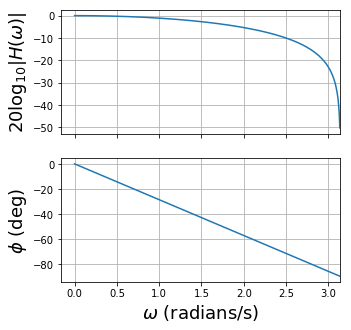

In [1]:
from __future__ import division
from numpy import angle, arange, conj, cos, fft, log10, pi, ones
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, subplots, subplot, show
%matplotlib inline


fig, axs = plt.subplots(2,1,sharex=True)
plt.subplots_adjust( hspace = .2 )
fig.set_size_inches((5,5))

ax = axs[0]
w, h = signal.freqz([1/2., 1/2.],1) # Compute impulse response
ax.plot(w, 20 * log10(abs(h)))
ax.set_ylabel(r"$20 \log_{10} |H(\omega)| $",fontsize=18)
ax.grid()

ax = axs[1]
ax.plot(w, angle(h) / pi * 180)
ax.set_xlabel(r'$\omega$ (radians/s)', fontsize=18)
ax.set_ylabel(r"$\phi $ (deg)", fontsize=18)
ax.set_xlim(xmax = pi)
ax.grid()

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


In the figure above, the top plot shows the amplitude response of the filter (in dB) and the bottom plot shows  the phase response in degrees. At $\omega=0 $, we have $|H(\omega=0)|=1 $ (i.e unity-gain) which says that our moving average filter does not change the amplitude of signals at $ \omega=0 $. We observed this earlier with $x_n=1 $ that produced $y_n=1 $. When we consider the other extreme with $\omega= \pi $, we have $|H(\omega=\pi)|=0$ which we observed earlier for $ x_n= \exp \left( j\pi n \right)  \hspace{.5em} \forall \hspace{.5em} n \ge 0 $. Thus, signals at $ \omega=\pi $ are completely zero-ed out by the filter.

Now, let's consider a signal halfway between this two extremes:

$$ x_n= \exp \left( j\pi n/2 \right)  \hspace{.5em} \forall \hspace{.5em} n \ge 0 $$

The following figure shows the filter's corresponding output.

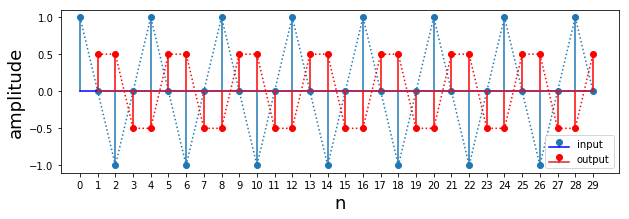

In [2]:
Ns = 30 # length of input sequence
n = arange(Ns) # sample index
x = cos(arange(Ns) * pi/2.)
y = signal.lfilter([1/2.,1/2.],1,x)

fig, ax = subplots(1,1)
fig.set_size_inches(10,3)

ax.stem(n, x, label='input', basefmt='b-')
ax.plot(n, x, ':')
ax.stem(n[1:], y[:-1], markerfmt='ro', linefmt='r-', label='output')
ax.plot(n[1:], y[:-1], 'r:')
ax.set_xlim(xmin=-1.1)
ax.set_ylim(ymin=-1.1, ymax=1.1)
ax.set_xlabel("n", fontsize=18)
ax.legend(loc=0)
ax.set_xticks(n)
ax.set_ylabel("amplitude", fontsize=18);

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The figure above shows the input/output time-domain response of the filter when  $\omega=\pi/2 $. At this point, $ |H(\omega)|^2 = 1/2 $ meaning the signal energy has been cut in half which is shown by the corresponding lower amplitude of the output signal. The signal phase has been shifted by 45 degrees. To see this, note that the input signal repeats every four samples (360 degrees). The graph above shows that the signal phase has shifted -45 degrees which is equivalent to a shift of one-half sample. Note that `signal.lfilter` automatically inserts a zero initial condition so we had to drop that one incomplete output point to line up the plots.  By interpreting the magnitude/phase plots above, we can reconcile the filter's input/output behavior in the time domain.    

What happens when we lengthen our moving average filter to consider averaging over eight samples instead of two?

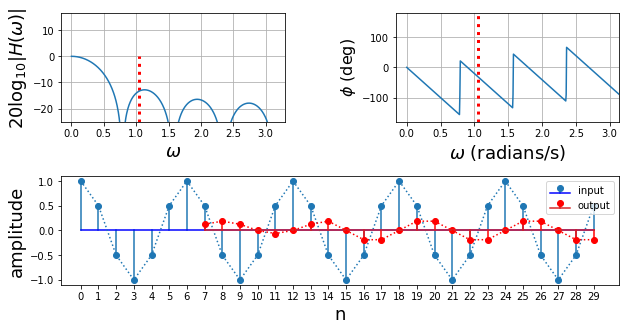

In [3]:
from matplotlib import gridspec

fig = figure()
fig.set_size_inches((10,5))

gs = gridspec.GridSpec(2,2)
gs.update( wspace=0.5, hspace=0.5)

ax = fig.add_subplot(subplot(gs[0,0]))

ma_length = 8 # moving average filter length
w, h = signal.freqz(ones(ma_length)/ma_length,1)
ax.plot(w,20*log10(abs(h)))
ax.set_ylabel(r"$ 20 \log_{10}|H(\omega)| $",fontsize=18)
ax.set_xlabel(r"$\omega$",fontsize=18)
ax.vlines(pi/3,-25,0,linestyles=':',color='r',lw=3.)
ax.set_ylim(ymin=-25)
ax.grid()

ax = fig.add_subplot(subplot(gs[0,1]))
ax.plot(w,angle(h)/pi*180)
ax.set_xlabel(r'$\omega$ (radians/s)',fontsize=18)
ax.set_ylabel(r"$\phi $ (deg)",fontsize=16)
ax.set_xlim(xmax = pi)
ax.set_ylim(ymin=-180,ymax=180)
ax.vlines(pi/3,-180,180,linestyles=':',color='r',lw=3.)
ax.grid()

ax = fig.add_subplot(subplot(gs[1,:]))
Ns = 30
n = arange(Ns)
x = cos(arange(Ns)*pi/3.)
y = signal.lfilter(ones(ma_length)/ma_length,1,x)

ax.stem(n,x,label='input',basefmt='b-')
ax.plot(n,x,':')
ax.stem(n[ma_length-1:],y[:-ma_length+1],markerfmt='ro',linefmt='r-',label='output')
ax.plot(n[ma_length-1:],y[:-ma_length+1],'r:')
ax.set_xlim(xmin=-1.1)
ax.set_ylim(ymin=-1.1,ymax=1.1)
ax.set_xlabel("n",fontsize=18)
ax.set_xticks(n)
ax.legend(loc=0)
ax.set_ylabel("amplitude",fontsize=18);

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The figure above shows the magnitude and phase responses of the longer moving average filter. The zig-zag lines of the phase plot are due to the wrap-around of the phase as it wraps around   180 degree mark. The bottom plot shows the input/output sequences. Note that the output is delayed by the length of the input filter. Because the frequency of the input signal is $ 2\pi/6 $, its period is $T=6$ samples the input signal repeats every six samples. According to the phase plot above, the phase at this discrete frequency is approximately 30 degrees plus the 180 degree jump, the output sequence is shifted over by half a sample ($ 30/360 = 0.5/6 $) plus the 3 samples (half the six sample period, $ 180/360=1/2 $). Note that the magnitude plot shows multiple lobes and dips at discrete frequencies where the output is zero-ed out by the filter. Thus, even though we just lengthened our moving average filter by a few samples, we have encountered much more complicated amplitude and phase behavior. We need to assemble the right tools to understand this problem in general.

##  Fourier Transform of the Discrete Sequence

So far in these pages, we have considered samples of the Fourier transform      at discrete frequences ($ \omega = \frac{2\pi}{N} k $). Now we want to consider the Fourier Transform of the discrete input at *continuous* frequency defined as the following:

$$ H(\omega) = \sum_{n\in \mathbb{Z}} h_n \exp \left( -j\omega n \right) $$ 

Note that this is periodic, $H(\omega)=H(\omega+2\pi)$.

### Filter output as discrete convolution

The discrete convolution of infinite sequences $ x_n $ and $ h_n $ is defined as

$$ y_n = \sum_{k\in \mathbb{Z}} x_k^* h_{n-k} $$

where the asterisk superscript denotes  complex conjugation.  If we have a finite filter length of $ M $ ($ h_n =0, \forall n \notin \{0,1,...,M-1\} $), then the filter output reduces to

$$ y_n = \sum_{k=0}^{M-1} h_k x_{n-k} $$ 

Note this is closely related to but not the  same as the circular convolution we have already discussed because there is no wrap-around. However, because it is very efficient to compute this using a DFT, we need to relate these two versions of convolution. 

### Convolution using the DFT

If $x_n$ is nonzero for $ P $ samples, then the output $ y_n $ is non-zero only for $ P+M-1 $ samples. Thus, if we zero-pad each sequence out to this length, take the DFT, multiply the DFTs, and then invert the DFTs, we obtain the results of this non-circular convolution. Let's code this up below using our last example.

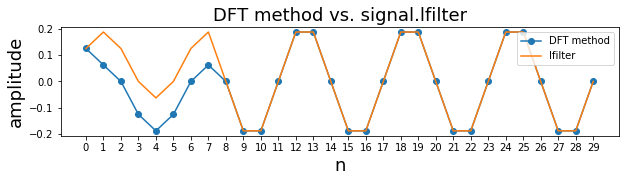

In [4]:
h=ones(ma_length)/ma_length # filter sequence
yc=fft.ifft(fft.fft(h,len(x)+len(h)-1)*conj(fft.fft(x,len(x)+len(h)-1))).real

fig,ax = subplots()
fig.set_size_inches((10, 2))
ax.plot(n,yc[ma_length-1:], 'o-',label='DFT method')
ax.plot(n, y, label='lfilter')
ax.set_title('DFT method vs. signal.lfilter',fontsize=18)
ax.set_xlabel('n',fontsize=18)
ax.set_ylabel('amplitude', fontsize=18)
ax.legend(loc=0)
ax.set_xticks(n);
show()

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The figure above compares the filter output sequence computed using the DFT and `signal.lfilter`. The only difference is the transient startup section $ M-1 $ where the taps of the filter have not filled out. This technique is fine for processing blocks of convenient size and there are many other methods (e.g. overlap-add) to compute this using different blocks that patch together the output while dealing with these transient effects.  



## Filter Transfer Functions

By keeping track of summation indicies, but it is not hard to show that

$$ Y(\omega) = H(\omega) X(\omega) $$

where $H(\omega)$ is called the *transfer function* or the *frequency response* of the filter $ h_n $. This product of transforms is much easier to work with than convolution and allows us to understand filter performance through the properties of $ H(\omega) $.

In our last example, by simply increasing the length of the moving average filter, we obtained many more zeros in $ H(\omega) $. Because our filters produce real outputs $ y_n $ given real inputs, $ x_n $, the zeros of the $ H(\omega) $ must be in complex conjugate pairs. To analyze this, we need to generalize the   Fourier Transfrom to the *z-transform*. 

### Z-Transform

The filter's z-transform is defined as the following:

$$ H(z) = \sum_n h_n z^{-n} $$ 

The Fourier transform is a special case of the z-transform evaluated on the unit circle ($ z=\exp(j\omega) $), but $z$ more generally spans the entire complex plane. Thus, to understand how our moving average filter removes frequencies, we need to compute the complex roots of the z-transform of $ h_n $ as

$$ H(z) = \sum_n h_n z^{-n} $$ 

This notation emphasizes the transfer function as a polynomial of the complex variable $z$. Thus, for our eight-tap moving average filter, we have

$$ H(z) = \sum_{n=0}^{M-1} h_n z^{-n} = \frac{1}{8} \sum_{n=0}^7 z^{-n} =\frac{1}{8}  (1+z)(1+z^2)(1+z^4)/z^7 $$

Thus, the first zero occurs when $z=-1$ or when $ \exp(j\omega) = -1 \Rightarrow \omega=\pi$. The next pair of zeros occurs when $z= \pm j$ which corresponds to $ \omega = \pm \pi/2 $. Finally, the last four zeros are for $\omega=\pm \pi/4$ and $\omega=\pm 3\pi/4 $.  Notice that any filter with this  $ z+1 $ term will  eliminate the $ \omega=\pi $ (highest) frequency. Likewise, the term $ z-1 $ means that the filter zeros out $ \omega=0 $. In general, the roots of the z-transform *do not* lie on the unit circle. One way to understand FIR filter design is as the judicious placement of these zeros in the complex plane so the shape of the resulting transfer function $ H(z) $ evaluated on the unit circle satisfies our design specifications.

We need a special case of the Fourier transform as a tool for our analysis. 

## Symmetry

There is a special case when the input sequence is symmetric,

$$ x_n = x_{-n} $$

which leads to a real-valued (i.e. zero-phase) Fourier transform property,

$$ H(\omega)= x_0+\sum_{n \gt 0} 2 x_n \cos\left(\omega n \right) $$

When the input is anti-symmetric,

$$ x_n = -x_{-n} $$

$$ H(\omega)= j\sum_{n \gt 0} 2 x_n \sin\left(\omega n \right) $$

The Fourier transform is purely imaginary (phase = $ \pi/2 $). Note that $ x_n = -x_{-n} $ for $ n=0 $ means that $ x_0=0 $ for this case.

## Causality

By changing the indexing in our first moving average filter example from  $ h_0 = h_1 = 1/2$ to $ h_{-1} = h_1 =1/2$, then we have symmetry around zero with the  resulting Fourier  transform,

$$ H(\omega) = \frac{1}{2} \exp \left( j\omega \right) +  \frac{1}{2} \exp\left( -j\omega \right) = \cos(\omega) $$

which is a *real* function of frequency (with zero-phase). While this is  nice theoretically, it is not possible practically because it requires future-knowledge of input sequence as shown below

$$ y_n = \sum_{k=0}^{M-1} h_n x_{n-k} = y_n = h_{-1} x_{n+1}+h_{1} x_{n-1} = \left( x_{n+1}+x_{n-1} \right)/2  $$

which shows that $ y_n $ depends on th future value of $ x_{n+1} $. This is what non-causal means and we must omit this kind of symmetry about zero from our class of admissible filter coefficents. However, we can scoot the  symmetric point to the center of the sequence at the cost of introducing a linear phase factor, $ \exp\left(-j\omega (M-1)/2 \right) $. Filters with linear phase do not distort the input phase across frequency. This means that all frequency components of the signal emerge at the other end of the filter in the same order they entered it. This is the concept of *group delay*. Otherwise, it would be very hard to retrieve any information embedded in the signal's phase in later  processing. Thus, we can build  linear phase causal filters with symmetric coefficients,

$$ h_n = h_{M-1-n} $$

or anti-symmetric coefficients,

$$ h_n = -h_{M-1-n} $$

by putting the point of symmetry at $ (M-1)/2 $. Note that this symmetry means that efficient hardware implementations can re-use stored filter coefficients.

## Symmetry and Anti-symmetry

Now we know how to build linear phase filters with symmetric or anti-symmetric coefficients and enforce causality by centering the point of symmetry, we can collect these facts and examine the resulting consequences. Given

$$ h_n = \pm h_{M-1-n} $$

with $ h_n =0 \hspace{0.5em} \forall n \ge M \wedge \forall n \lt 0 $ 

For even $ M $, the z-transform then becomes,

$$ H(z) = \sum_{n=0}^{M-1} z^{-n} h_n = h_0 + h_1 z^{-1} +\ldots + h_{M-1}z^{-M+1}= z^{-(M-1)/2} \sum_{n=0}^{M/2-1} h_n \left( z^{(M-1-2 n)/2} \pm z^{-(M-1-2 n)/2}\right) $$

Likewise, for odd $ M $,

$$ H(z) =  z^{-(M-1)/2} \left\lbrace h_{(M-1)/2}+ \sum_{n=0}^{(M-3)/2} h_n \left( z^{(M-1-2 n)/2} \pm z^{-(M-1-2 n)/2}\right) \right\rbrace$$

By substituting $ 1/z $ and multiplying both sides by $ z^{-(M-1)} $, we obtain

$$ z^{-(M-1)}H(z^{-1}) = \pm H(z) $$

This equation shows that if $z$ is a root, then so is $1/z$, and since we want a real-valued impulse response, complex roots must appear in conjugate pairs. Thus if $z_1$ is complex valued, then $ z_1^* $ is also a root and so is $1/z_1$ and $ 1/z_1^* $. Thus, one complex root  generates *four* roots.  This means that having $ M $ taps on the filter does not imply $M$ independent choices of the filter's roots or of the filter's coefficents. The symmetry conditions reduce the number of degrees of freedom available in the design.

### Extracting the Real Part of the Filter Transfer Function

We can evaluate these results  on the unit circle when $ h_n = +h_{M-n-1}$to obtain the following,

$$ H(\omega) = H_{re}(\omega)\exp \left( -j\omega(M-1)/2 \right) $$

where $ H_{re}(\omega)$ is a real-valued function that can be written as

$$ H_{re}(\omega) = 2 \sum_{n=0}^{(M/2)-1} h_n \cos \left( \omega \frac{M-1-2 n}{2}  \right) $$

for even $ M $ and as 

$$ H_{re}(\omega) = h_{(M-1)/2}+ 2\sum_{n=0}^{(M-3)/2} h_n  \cos \left( \omega \frac{M-1-2 n}{2}  \right) $$

for odd $ M $. Similar results follow when $ h_n = -h_{M-1-n} $. For $ M $ even, we have

$$ H_{re}(\omega) = 2 \sum_{n=0}^{M/2-1} h_n \sin \left( \omega \frac{M-1-2 n}{2} \right) $$

and for odd $M$.

$$ H_{re}(\omega) = 2 \sum_{n=0}^{(M-3)/2} h_n \sin \left( \omega \frac{M-1-2 n}{2} \right) $$

By narrowing our focus to $ H_{re}(\omega)$ and separating out the linear-phase part, we can formulate design techniques that focus solely on this real-valued function, as we will see later with Parks-McClellen FIR design. 

The table below shows the number of *independent* filter coefficients that must be specified for a FIR filter in each case.

<table border="1">
    <tr>
    <th>  </th>
    <th> even M</th>
    <th> odd M </th>
    </tr>
    <tr>
        <td>symmetric</td><td>M/2</td><td style="text-align:center">(M+1)/2</td>
    </tr>
    <tr>
        <td>anti-symmetric</td><td>M/2</td><td style="text-align:center"> (M-1)/2</td>
    </tr>
</table> 

The design problem is finding the coefficents that satisfy a  filter's specifications. Picking any of the cases shown in the table depends on the application. For example, for odd $ M $ and the anti-symmetric case, $ H_{re}(\omega=0)= H_{re}(\omega=\pi)= 0 $ so this would be a bad choice for high or low pass filters. 

Because many books refer to the items in this table as type-I through type-IV filters, I'm including this terminology in the table below. 

<table border="1">
    <tr>
    <th>  </th>
    <th> even M</th>
    <th> odd M </th>
    </tr>
    <tr>
        <td>symmetric</td><td>type-I</td><td style="text-align:center">type-II</td>
    </tr>
    <tr>
        <td>anti-symmetric</td><td>type-III</td><td style="text-align:center"> type-VI</td>
    </tr>
</table> 

### Example

We can use these results to reconsider our earlier result for the two-tap moving average filter for which $ M=2 $ and $ h_0 = 1/2 $. Then,

$$ H_{re}(\omega) =  \cos \left( \omega/2 \right) $$

with phase,

$$ \exp \left( -j\omega(M-1)/2 \right) = \exp \left( -j\omega/2 \right)$$

which equals $ \exp (-j\pi/4) $ when $ \omega = \pi/2 $ as we observed numerically earlier.

## Summary

In this section, we began our work with FIR filters by considering the concepts of linear phase, symmetry, and causality. By defining FIR filter coefficients symmetrically, we were able to enforce both causality and linear phase. We introduced the continuous-frequency version of the Fourier Transform and its relationship to the Discrete Fourier Transfrom (DFT). We demonstrated how the circular convolution of the DFT can be used to compute the continuous-frequency Fourier Transform version of the convolution. Then, we  introduced the z-transform as a more general tool than the Fourier transform for understanding the role of zeros in filter design. All this led us to conditions on the filter coeffients that satisfy our practical requirements of linear phase (no phase-distortions across frequency) and causality (no future knowledge of inputs). Finally, we considered the mathematical properties of FIR filters that apply to *any* design.

Sadly, all this work is exactly backwards because all our examples so far started with a set of filter coefficients ($ h_n $) and then drew conclusions, numerically and analytically, about their consequences. In a real, situation, we start with a desired filter specification, and *then* (by various means) come up with the corresponding filter coefficients. Our next section explores this topic.


As usual, the corresponding IPython notebook for this post  is available for download [here](https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Filtering.ipynb). 

Comments and corrections welcome!

References
---------------

* Proakis, John G. ,*Digital signal processing: principles algorithms and applications*. Pearson Education India, 2001.